# ~ 環境準備

In [1]:
# 掛載雲端硬碟 Mount google drive in CoLab enviroment
#from google.colab import drive
#drive.mount('gdrive')

In [2]:
# 匯入需要的 python 模組
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf  
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from IPython import display
# 聲音套件 https://librosa.org/doc/main/index.html  
import librosa
import librosa.display
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, recall_score
from itertools import cycle, product
from scipy import interp

In [3]:
# 變更工作資料夾 --> 自己組別的資料夾 ex."/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/第01大組_"
my_working_root = "/Users/zhongyongting/1112/ai_workshop"
os.chdir(my_working_root)

# 1 資料處理
|變項(中文)|變項(英文)|Coding|說明(中文)|說明(英文)|
|---|---|---|---|---|
|嗓音診斷分類(target)|Disease category|1/2/3/4/5|嗓音誤用/聲帶閉合不全/聲帶麻痺/聲帶腫瘤/聲帶正常|Phonotrauma/Incomplete glottic closure/Vocal palsy/Neoplasm/Normal|
|性別|Sex|1/2|男性/女性|Male/Female
|年齡|Age|numbers| |  	
|音域變窄|Narrow pitch range|0/1|無/有|No/Yes
|說話音量變小|Decreased volume|0/1|無/有|No/Yes
|說話久了容易累|Fatigue|0/1|無/有|No/Yes
|喉嚨常覺得乾|Dryness|0/1|無/有|No/Yes
|喉嚨有異物感|Lumping|0/1|無/有|No/Yes
|胸口有灼熱感|Heartburn|0/1|無/有|No/Yes
|吞東西容易嗆到|Choking|0/1|無/有|No/Yes
|眼睛乾澀|Eye dryness|0/1|無/有|No/Yes
|鼻涕倒流|PND|0/1|無/有|No/Yes
|糖尿病|Diabetes|0/1|無/有|No/Yes
|高血壓|Hypertension|0/1|無/有|No/Yes
|心臟病|CAD|0/1|無/有|No/Yes
|頭頸部腫瘤|Head and Neck Cancer|0/1|無/有|No/Yes
|頭部損傷|Head injury|0/1|無/有|No/Yes
|腦中風|CVA|0/1|無/有|No/Yes
|抽菸|Smoking|0/1/2/3|從未/已戒菸/有抽菸/電子菸|Never/past/active/e-cigarette
|PPD|PPD|numbers|一天幾包菸|pack (of cigarrette) per day
|喝酒|Drinking|0/1/2|從未喝酒/已戒酒/有喝酒|Never/past/active 
|喝酒頻率|Frequency|0/1/2/3|偶爾喝/每周喝/幾乎每天|Not/occasionally/ weekly/daily 
|症狀如何發生的|Onset of dysphonia|1/2/3/4/5|突然/逐漸變差/時好時壞/從小開始/其他|Sudden/Gradually/On and off/Since childhood/Other 
|工作環境是否吵雜|Noise at work|1/2/3|否/有一點/很吵|Not/a little/noisy 
|聲音何時最差|Diurnal pattern|1/2/3/4|早上/下午、晚上 /都一樣/不一定|Worse in the morning/Worse in the afternoon/Similar all day/Fluctuating 
|用聲情形|Occupational vocal demand|1/2/3/4|總是需要/經常需要/偶而需要/不需要|Always/Frequent/Occasional/Minimal 
|VHI-10嗓音障礙指標|Voice handicap index - 10|0 to 40| |		

In [4]:
# 讀取資料表
df = pd.read_csv("/Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training datalist.csv")
df = df.loc[df['Sex'] == 1]
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
1,0600ve0,1,69,2,1,1,1,1,0,0,...,2,1,3,0,0,0,0,0,1,19.0
4,0402jvt,1,87,1,0,0,0,0,0,0,...,1,1,4,0,1,0,0,0,0,16.0
9,11019sl,1,51,1,1,1,0,1,1,0,...,2,3,2,0,1,0,0,0,0,14.0
14,0402svh,1,91,4,0,0,0,0,0,0,...,2,1,4,0,0,0,0,0,0,7.0
15,0T0018b,1,74,3,0,1,0,1,0,0,...,1,1,3,0,1,0,0,0,0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,1,35,1,1,0,1,1,1,1,...,2,2,1,0,0,0,0,0,0,28.0
994,0T022un,1,52,3,1,1,0,0,0,0,...,2,1,3,0,0,0,0,0,0,37.0
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,1,1,4,1,1,1,0,0,0,21.0
996,1201pkr,1,40,4,0,0,1,0,0,0,...,2,1,2,0,0,0,0,0,0,21.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 1 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         378 non-null    object 
 1   Sex                        378 non-null    int64  
 2   Age                        378 non-null    int64  
 3   Disease category           378 non-null    int64  
 4   Narrow pitch range         378 non-null    int64  
 5   Decreased volume           378 non-null    int64  
 6   Fatigue                    378 non-null    int64  
 7   Dryness                    378 non-null    int64  
 8   Lumping                    378 non-null    int64  
 9   heartburn                  378 non-null    int64  
 10  Choking                    378 non-null    int64  
 11  Eye dryness                378 non-null    int64  
 12  PND                        378 non-null    int64  
 13  Smoking                    378 non-null    int64  

## 1.0 標籤分析

1    138
2    115
3     79
4     33
5     13
Name: Disease category, dtype: int64

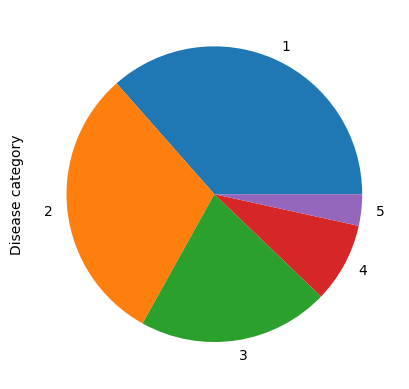

In [6]:
# 分類標籤
CLASSES = ["Phonotrauma", "Incomplete glottic closure", "Vocal palsy", "Neoplasm", "Normal"]
df['Disease category'].value_counts().plot.pie()
df['Disease category'].value_counts()

In [7]:
# 樣本權重 sample weight  (for imbalance data)
df['sample_weight'] = class_weight.compute_sample_weight('balanced', y=df['Disease category'])
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,sample_weight
1,0600ve0,1,69,2,1,1,1,1,0,0,...,1,3,0,0,0,0,0,1,19.0,0.657391
4,0402jvt,1,87,1,0,0,0,0,0,0,...,1,4,0,1,0,0,0,0,16.0,0.547826
9,11019sl,1,51,1,1,1,0,1,1,0,...,3,2,0,1,0,0,0,0,14.0,0.547826
14,0402svh,1,91,4,0,0,0,0,0,0,...,1,4,0,0,0,0,0,0,7.0,2.290909
15,0T0018b,1,74,3,0,1,0,1,0,0,...,1,3,0,1,0,0,0,0,15.0,0.956962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,1,35,1,1,0,1,1,1,1,...,2,1,0,0,0,0,0,0,28.0,0.547826
994,0T022un,1,52,3,1,1,0,0,0,0,...,1,3,0,0,0,0,0,0,37.0,0.956962
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,1,4,1,1,1,0,0,0,21.0,0.956962
996,1201pkr,1,40,4,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,21.0,2.290909


## 1.1 添加音檔路徑

In [8]:
# 檔案名稱為 {ID}.wav
training_voice_dir = "/Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training_voice_data"
df['path'] = df['ID'].map(lambda x: f"{training_voice_dir}/{x}.wav")
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,sample_weight,path
1,0600ve0,1,69,2,1,1,1,1,0,0,...,3,0,0,0,0,0,1,19.0,0.657391,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
4,0402jvt,1,87,1,0,0,0,0,0,0,...,4,0,1,0,0,0,0,16.0,0.547826,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
9,11019sl,1,51,1,1,1,0,1,1,0,...,2,0,1,0,0,0,0,14.0,0.547826,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
14,0402svh,1,91,4,0,0,0,0,0,0,...,4,0,0,0,0,0,0,7.0,2.290909,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
15,0T0018b,1,74,3,0,1,0,1,0,0,...,3,0,1,0,0,0,0,15.0,0.956962,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,1,35,1,1,0,1,1,1,1,...,1,0,0,0,0,0,0,28.0,0.547826,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
994,0T022un,1,52,3,1,1,0,0,0,0,...,3,0,0,0,0,0,0,37.0,0.956962,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,4,1,1,1,0,0,0,21.0,0.956962,/Users/zhongyongting/1112/ai_workshop/Data/Tra...
996,1201pkr,1,40,4,0,0,1,0,0,0,...,2,0,0,0,0,0,0,21.0,2.290909,/Users/zhongyongting/1112/ai_workshop/Data/Tra...


## 1.2 讀取音檔

嗓音診斷分類： Incomplete glottic closure
音訊檔案路徑： /Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training_voice_data/0802vti.wav
音訊取樣頻率(sampling rate) = 22050 Hz    array shape = (66150,)    dtype = float32


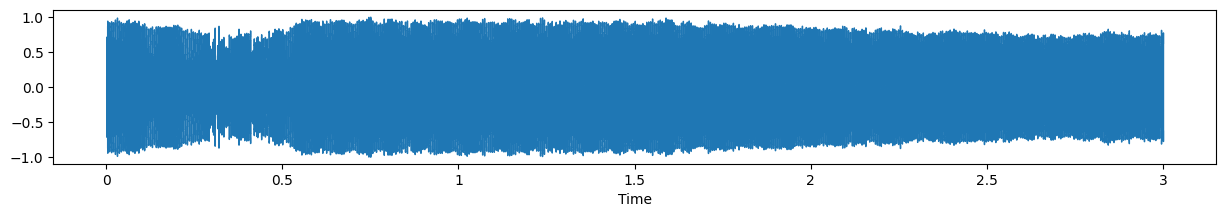

In [9]:
def load_wav(path, target_sr=22050, fix_length=None, normalize=True):
    """Read and normalize a wave file to np.array"""
    waveform, sr = librosa.load(path)
    if waveform.ndim > 1:  # convert to mono
        waveform = librosa.to_mono(waveform)
    if sr != target_sr:  # resmapling to target_sr
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    if fix_length != None:  # fix array length
        waveform = librosa.util.fix_length(waveform, size=fix_length)
    if normalize:
        waveform = waveform / np.abs(waveform).max()
    return waveform, sr

# function test:
idx = np.random.choice(df.index, size=1)[0]  # 隨機選一個資料索引
print("嗓音診斷分類：", CLASSES[df.loc[idx, 'Disease category'] - 1])
path = df.loc[idx, 'path']
print("音訊檔案路徑：", path)

waveform, sr = load_wav(path)

# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {waveform.shape}    dtype = {waveform.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(waveform, sr=sr)
plt.show()
display.display(display.Audio(waveform, rate=sr))

噪音處理

### 噪音處理

In [10]:
import os, glob
import numpy as np
from scipy import signal
from IPython import display
import matplotlib.pyplot as plt
# 聲音套件 https://librosa.org/doc/main/index.html  
import librosa
import librosa.display

In [11]:
# 檔案名稱為 {ID}.wav
training_voice_dir = "/Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training_voice_data"
wav_file_list = glob.glob(f"{training_voice_dir}/*.wav")
print("found wav files =", len(wav_file_list), wav_file_list[0])

found wav files = 1000 /Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training_voice_data/0702ulb.wav


音訊檔案路徑： /Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training_voice_data/1002ngi.wav
音訊取樣頻率(sampling rate) = 11025 Hz    array shape = (33075,)    dtype = float32


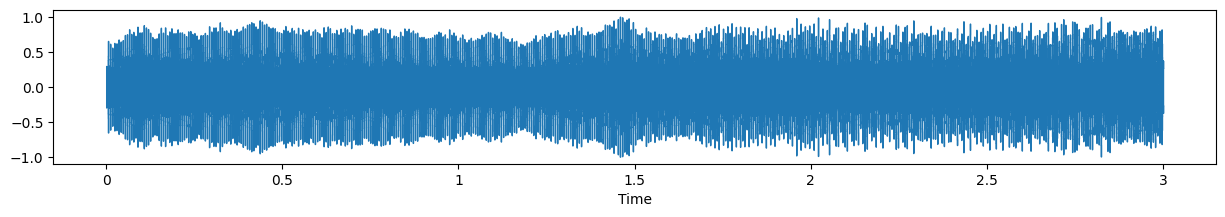

In [12]:
def load_wav(path, target_sr=11025, fix_length=None, normalize=True):
    """Read and normalize a wave file to np.array"""
    waveform, sr = librosa.load(path)
    if waveform.ndim > 1:  # convert to mono
        waveform = librosa.to_mono(waveform)
    if sr != target_sr:  # resmapling to target_sr
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    if fix_length != None:  # fix array length
        waveform = librosa.util.fix_length(waveform, size=fix_length)
    if normalize:
        waveform = waveform / np.abs(waveform).max()
    return waveform, sr

# function test:
idx = np.random.choice(len(wav_file_list), size=1)[0]  # 隨機選一個資料索引
path = wav_file_list[idx]
print("音訊檔案路徑：", path)

waveform, sr = load_wav(path)

# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {waveform.shape}    dtype = {waveform.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(waveform, sr=sr)
plt.show()
display.display(display.Audio(waveform, rate=sr))

音訊取樣頻率(sampling rate) = 11025 Hz    array shape = (33075,)    dtype = float64


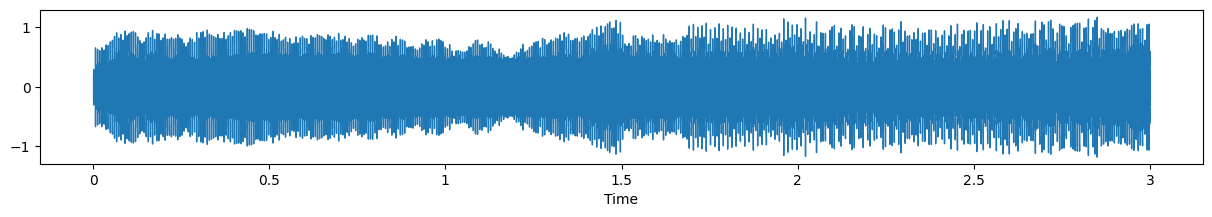

In [13]:
def high_pass_filter(y, sr, critical_freq=100): 
    b, a = signal.butter(10, critical_freq/(sr/2), btype='highpass')
    yf = signal.lfilter(b, a, y)
    return yf

# function test:
filtered = high_pass_filter(waveform, sr)
# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {filtered.shape}    dtype = {filtered.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(filtered, sr=sr)
plt.show()
display.display(display.Audio(filtered, rate=sr))

音訊取樣頻率(sampling rate) = 11025 Hz    array shape = (33075,)    dtype = float64


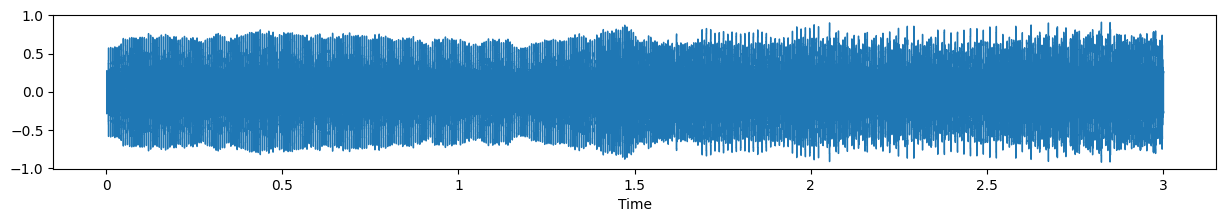

In [14]:
def low_pass_filter(y, sr, critical_freq=5000): 
    b, a = signal.butter(10, critical_freq/(sr/2), btype='lowpass')
    yf = signal.lfilter(b, a, y)
    return yf

# function test:
filtered = low_pass_filter(waveform, sr)
# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {filtered.shape}    dtype = {filtered.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(filtered, sr=sr)
plt.show()
display.display(display.Audio(filtered, rate=sr))

#### Method for noise reduction

In [15]:
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [16]:
from pydub import AudioSegment

# 10 seconds of each file
y1,sr = librosa.load(path, mono=True, offset=0, duration= 10)

Listen to them!

In [17]:
from IPython.display import Audio, IFrame, display

display(Audio(y1,rate=sr))

As you can hear, the first audio presents a high level background noise, and birds seems far from the mic. In the second audio, bird sounds are much more distinguished from the other noises. We can say that the second audio presents a better SNR (signal-noise ratio).

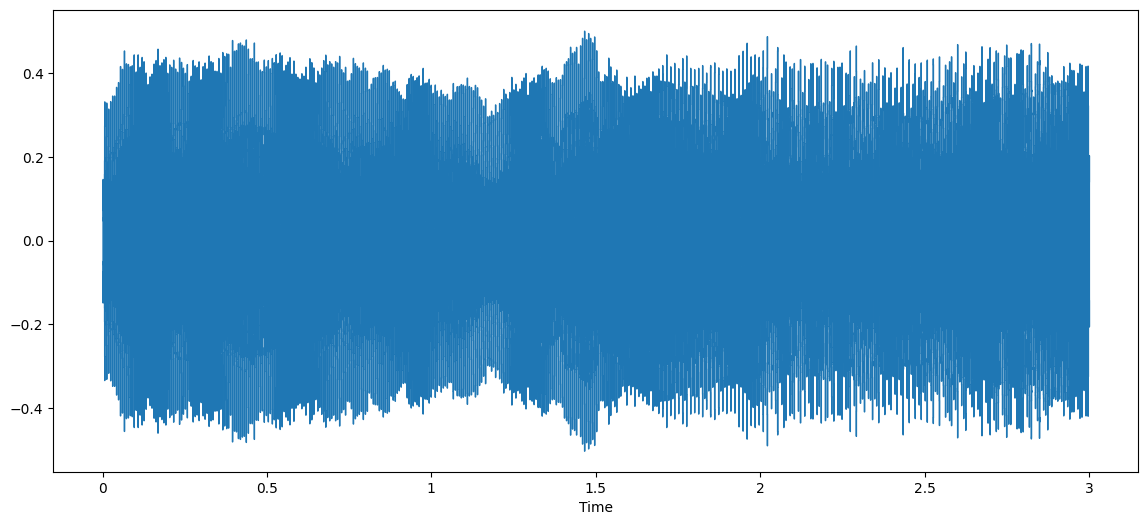

In [18]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');

In [19]:
#librosa.display.waveplot(y2,sr=sr, x_axis='time');

If you look to both signal waves, you can see that the first sound presents a lower difference between the background level and some sound events, while this difference is much higher in the second sound. If you do it in sync with the audio, we can see that some bird calls does not appear from the average sound level.

## Logmel-spectogram

A very common preprocessing technique in audio detection applications is to transform audios to its log mel-spectogram representation.
Some concepts here: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

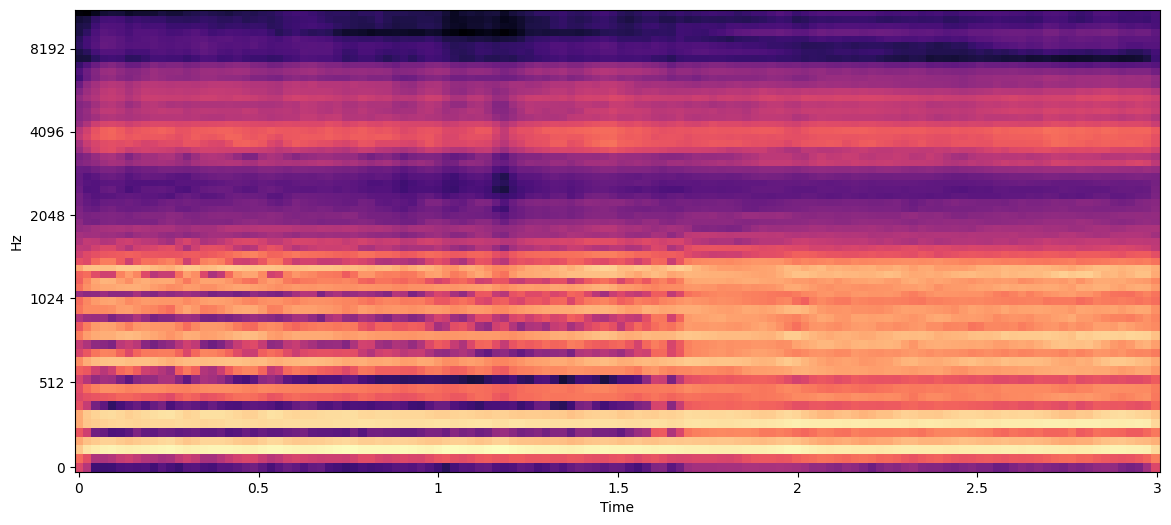

In [20]:
S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [21]:
#S2 = librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=64)
#D2 = librosa.power_to_db(S2, ref=np.max)
#librosa.display.specshow(D2, x_axis='time', y_axis='mel');

The differences become very clear in the log mel spectogram. In the fist case, you can see a lot of artefacts on low frequencies (not birds), and the birds are in levels below the background noises. Besides, background noises are higher in frequencies below 2 kHz.

## Filtering low-frequencies

As we noticed, low frequencies does not contribute to bird sounds, a first idea is to remove these low frequencies. A high pass filter helps in this task. Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

In [22]:
from scipy import signal
import random


def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf


In [23]:
yf1 = f_high(y1, sr)
#yf2 = f_high(y2, sr)

Let's see...

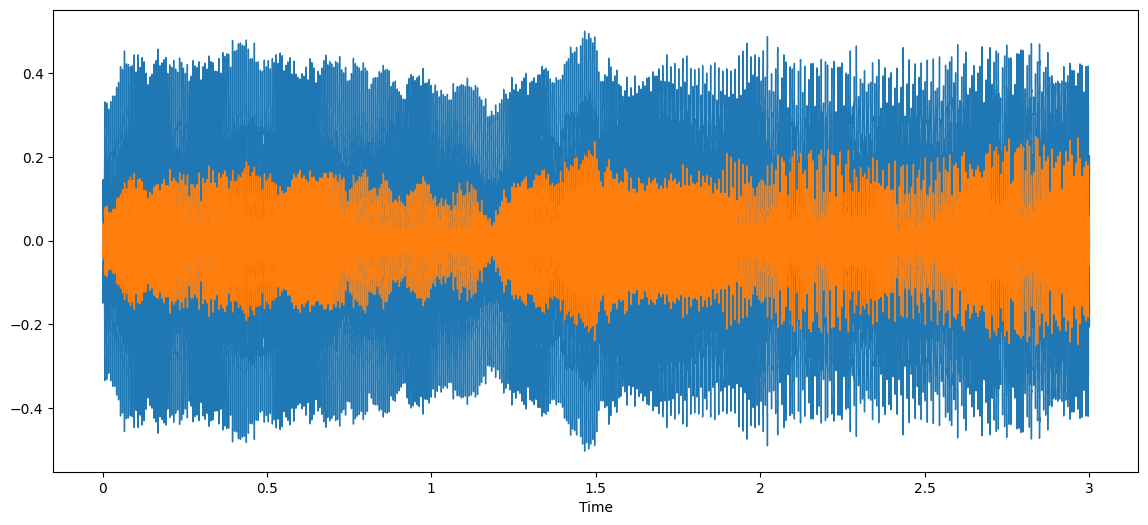

In [24]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');
librosa.display.waveshow(yf1,sr=sr, x_axis='time');

In [25]:
#librosa.display.waveplot(y2,sr=sr, x_axis='time');
#librosa.display.waveplot(yf2,sr=sr, x_axis='time');

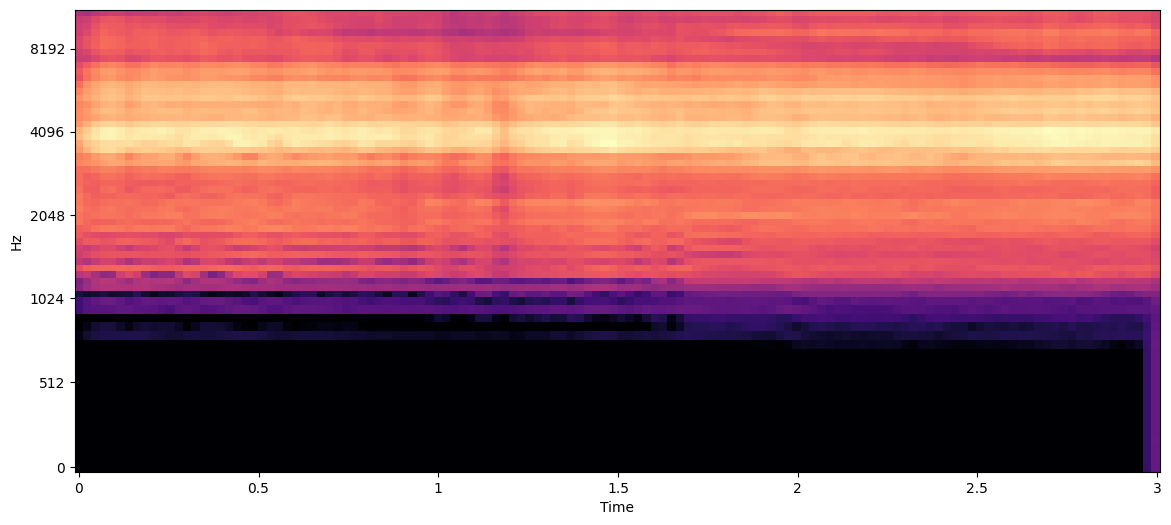

In [26]:
Sf1 = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=64)
Df1 = librosa.power_to_db(Sf1, ref=np.max)
librosa.display.specshow(Df1, x_axis='time', y_axis='mel');

In [27]:
#Sf2 = librosa.feature.melspectrogram(y=yf2, sr=sr, n_mels=64)
#Df2 = librosa.power_to_db(Sf2, ref=np.max)
#librosa.display.specshow(Df2, x_axis='time', y_axis='mel');

In [28]:
display(Audio(yf1,rate=sr))
#display(Audio(yf2,rate=sr))

In both cases, the filter helped to isolate the interesting frequencies. The second audio is in a very good quality for distincting the birds. But the first audio also have high level noises in bird frequencies. Simply removing these frequencies can make us loose important information.

## PCEN

PCEN has become a very useful strategy for acoustic event detection, and it has shown to perform better in such tasks as a frontend. Its idea is to perform non-linear compression on time-frequency channels.

I am using the example shown here: https://librosa.org/doc/latest/generated/librosa.pcen.html?highlight=pcen#librosa.pcen

In [29]:
Dp1 = librosa.pcen(S1 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)
#Dp2 = librosa.pcen(S2 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)

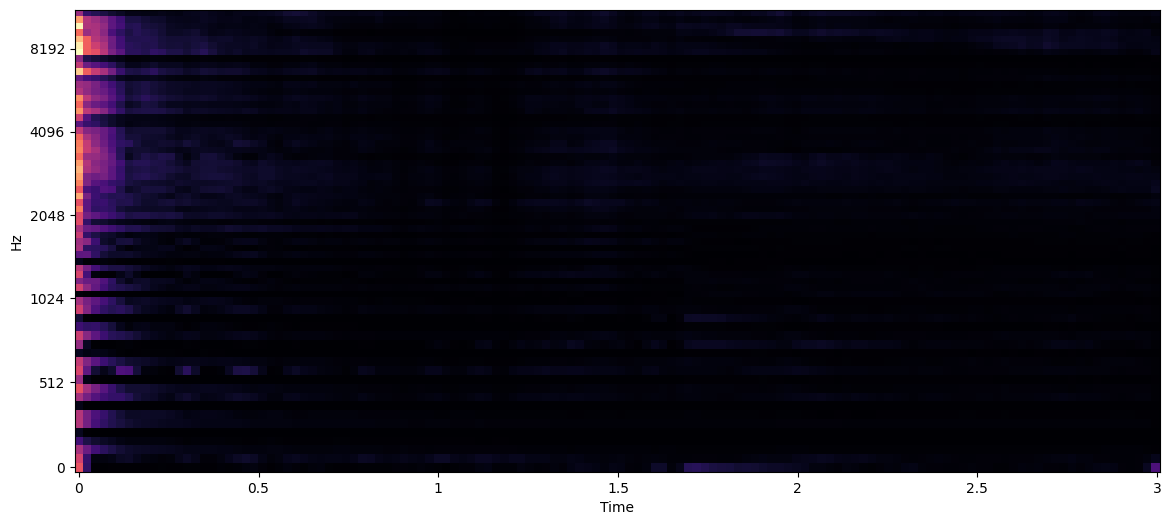

In [30]:
librosa.display.specshow(Dp1, x_axis='time', y_axis='mel');

In [31]:
#librosa.display.specshow(Dp2, x_axis='time', y_axis='mel');

In [32]:
yp1 = librosa.feature.inverse.mel_to_audio(Dp1)
#yp2 = librosa.feature.inverse.mel_to_audio(Dp2)

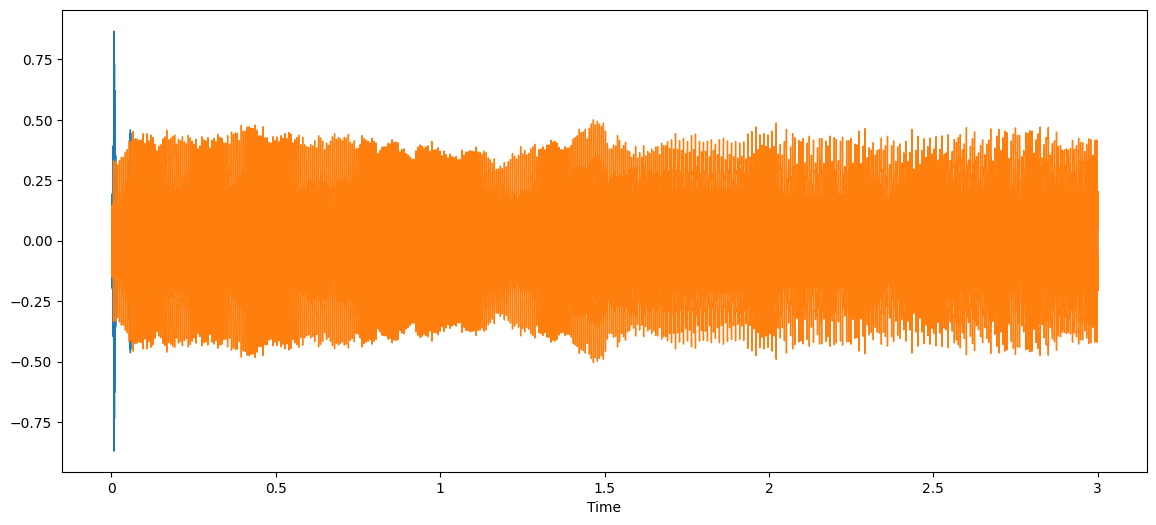

In [33]:
librosa.display.waveshow(yp1,sr=sr, x_axis='time');
librosa.display.waveshow(y1,sr=sr, x_axis='time');

In [34]:
#librosa.display.waveplot(yp2,sr=sr, x_axis='time');
#librosa.display.waveplot(y2,sr=sr, x_axis='time');

In [35]:
display(Audio(yp1,rate=sr))
#display(Audio(yp2,rate=sr))

Uowwwww! It looks very promising!
This method does not eliminate all background, but the bird signal shapes are much more visible in the spectograms.
This method works on time-frequency representarions of the sounds, so I perform signal reconstitution from spectogram to audio to gives us a good idea on how it worked. This recostitution is not perfect, some artefacts are inserted.

## Spectral Gating

This is also a technique for noise reduction based on gates that monitor audio level. It is commonly used in music industry, and present in tools like Audacity (https://wiki.audacityteam.org/wiki/How_Audacity_Noise_Reduction_Works).
I reproduced here the code made available by Tim Sainburg in his github (https://github.com/timsainb/noisereduce).

In [36]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    # return librosa.istft(y)
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    #print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [37]:
noise1 = y1[5*sr:6*sr]
yg1 = removeNoise(audio_clip=y1, noise_clip=noise1,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)

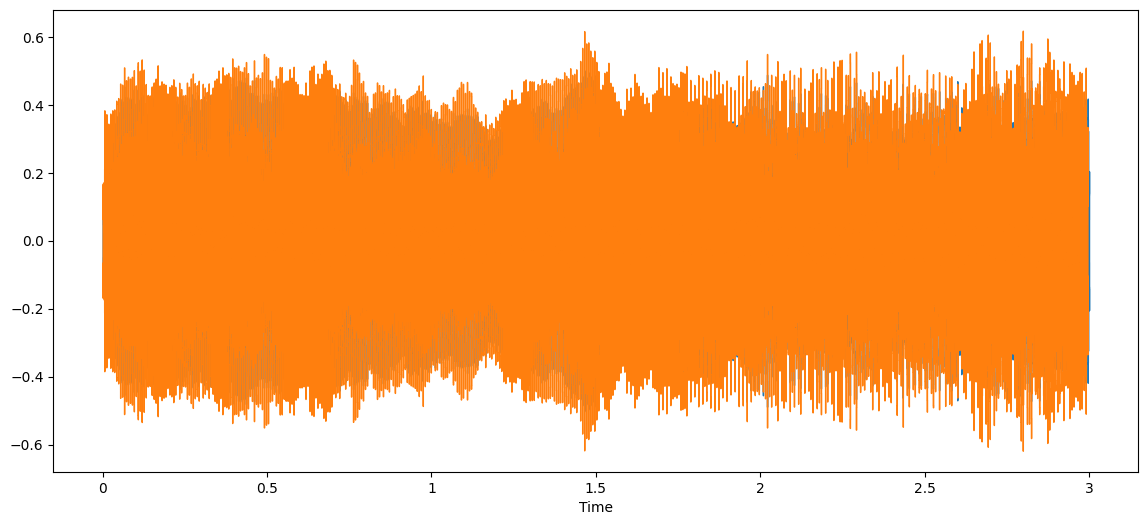

In [38]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');
librosa.display.waveshow(yg1,sr=sr, x_axis='time');

In [39]:
#librosa.display.waveplot(y2,sr=sr, x_axis='time');
#librosa.display.waveplot(yg2,sr=sr, x_axis='time');

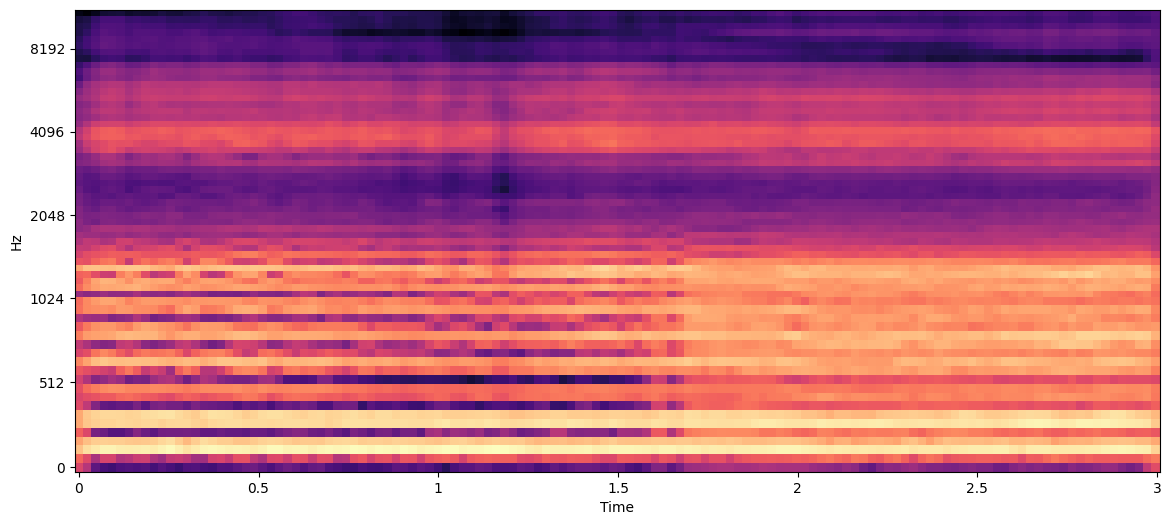

In [40]:
Sg1 = librosa.feature.melspectrogram(y=yg1, sr=sr, n_mels=64)
Dg1 = librosa.power_to_db(Sg1, ref=np.max)
librosa.display.specshow(Dg1, x_axis='time', y_axis='mel');

In [41]:
#Sg2 = librosa.feature.melspectrogram(y=yg2, sr=sr, n_mels=64)
#Dg2 = librosa.power_to_db(Sg2, ref=np.max)
#librosa.display.specshow(Dg2, x_axis='time', y_axis='mel');

In [42]:
display(Audio(yg1,rate=sr))
#display(Audio(yg2,rate=sr))

## 1.3 音訊轉2D特徵圖
n_fft ,hop_length 到底什麼 https://ithelp.ithome.com.tw/articles/10260738?sc=iThelpR

S shape = (1025, 65) [ 0.00 ~ 129.24 ]


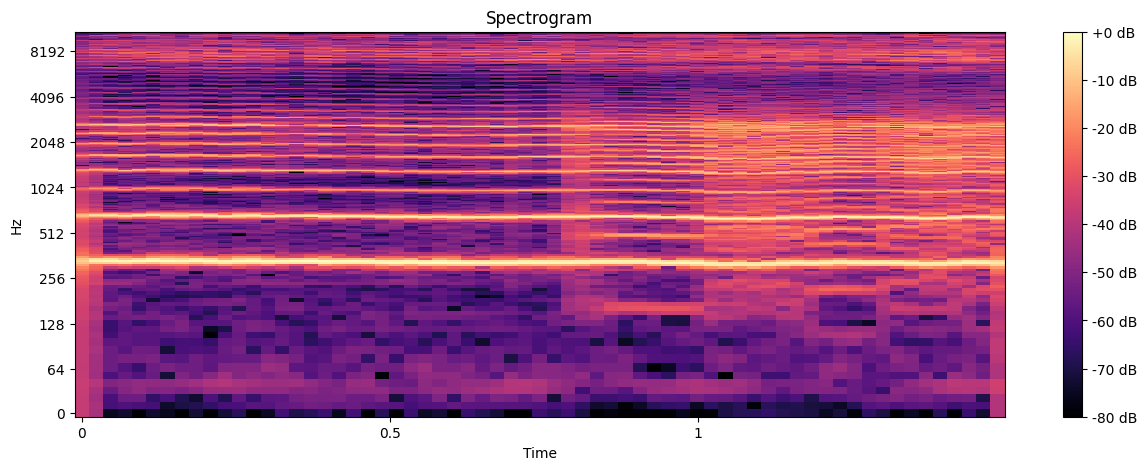

In [43]:
#@title 頻譜圖 (Spectrogram)
# 短時間傅立葉轉換 (Short-time Fourier Transform, STFT)
# https://librosa.org/doc/main/generated/librosa.stft.html
def wav_to_stft(waveform, sr):
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    S = np.abs(librosa.stft(waveform, n_fft=n_fft))
    return S #/ S.max()  # normalized output

# function test:
S = wav_to_stft(waveform, sr)
print(f"S shape = {S.shape} [ {S.min():.2f} ~ {S.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, y_axis='log', x_axis='time')
# librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, y_axis='linear', x_axis='time')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.show()

mel_S shape = (128, 65) [ 0.00 ~ 856.55 ]


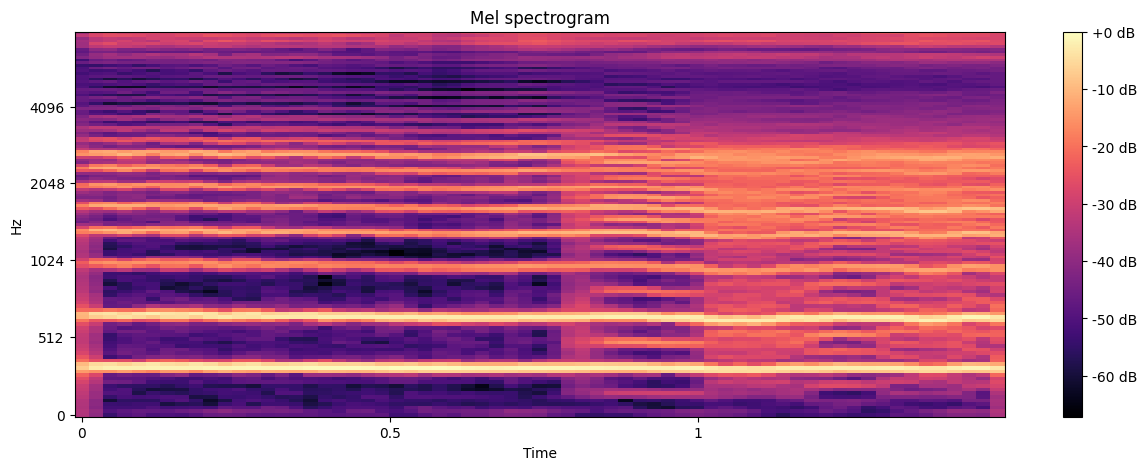

In [44]:
#@title 梅爾(較注重低頻，人聲較為適合) 頻譜圖 (Mel Spectrogram)
# https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
# https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def wav_to_mel_spec(waveform, sr):
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec，窄的音框適合分析短時間的變化。)
    n_mels = 128  # 頻帶數量
    fmax = 8000  # 最高頻率
    mel_S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    return mel_S #/ mel_S.max()  # normalized output

# function test:
mel_S = wav_to_mel_spec(waveform, sr)
print(f"mel_S shape = {mel_S.shape} [ {mel_S.min():.2f} ~ {mel_S.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.power_to_db(mel_S, ref=np.max), sr=sr, y_axis='mel', x_axis='time', fmax=8000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram")
plt.show()

mfccs shape = (20, 65) [ -144.31 ~ 74.70 ]


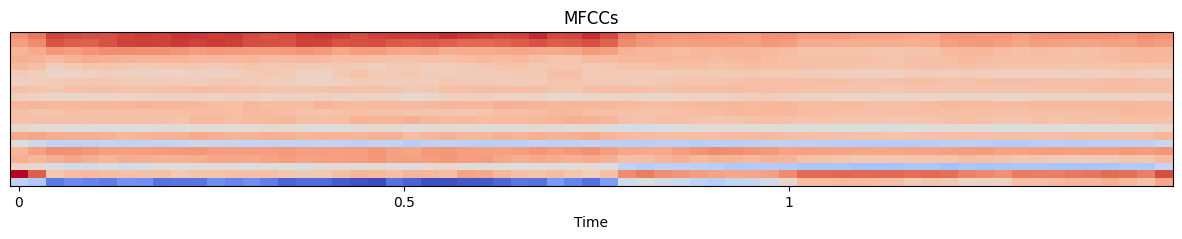

In [45]:
#@title 梅爾頻率倒譜係數 (Mel-frequency cepstral coefficients, MFCC)
# https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
def wav_to_mfcc(waveform, sr):
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    n_mels = 128  # 頻帶數量
    fmax = 8000  # 最高頻率
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=20, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    return mfccs

# function test:
mfccs = wav_to_mfcc(waveform, sr)
print(f"mfccs shape = {mfccs.shape} [ {mfccs.min():.2f} ~ {mfccs.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 2))
librosa.display.specshow(mfccs, x_axis='time')
plt.title("MFCCs")
plt.show()

mfcc_delta shape = (40, 65) [ -144.31 ~ 74.70 ]


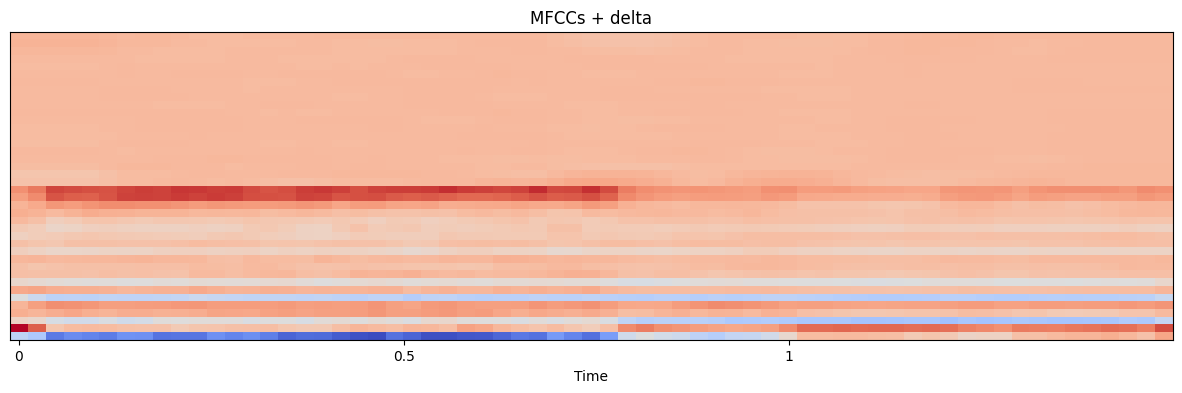

In [46]:
# 梅爾頻率倒譜係數 + 差量 特徵
# https://blog.maxkit.com.tw/2019/
def wav_to_mfccs_delta(waveform, sr):  
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    n_mels = 128  # 頻帶數量
    fmax = 8000  # 最高頻率
    mfcc_feature = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=20, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    delta_mfcc_feature = librosa.feature.delta(mfcc_feature)
    mfcc_delta = np.concatenate((mfcc_feature, delta_mfcc_feature))
    return mfcc_delta

# function test:
mfcc_delta = wav_to_mfccs_delta(waveform, sr=sr)
print(f"mfcc_delta shape = {mfcc_delta.shape} [ {mfcc_delta.min():.2f} ~ {mfcc_delta.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 4))
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title("MFCCs + delta")
plt.show()

## 1.4 處理 目標欄位 (target)

In [47]:
df_trans = pd.get_dummies(df, columns=['Disease category'])
df_trans

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Head injury,CVA,Voice handicap index - 10,sample_weight,path,Disease category_1,Disease category_2,Disease category_3,Disease category_4,Disease category_5
1,0600ve0,1,69,1,1,1,1,0,0,1,...,0,1,19.0,0.657391,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,0,1,0,0,0
4,0402jvt,1,87,0,0,0,0,0,0,0,...,0,0,16.0,0.547826,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,1,0,0,0,0
9,11019sl,1,51,1,1,0,1,1,0,0,...,0,0,14.0,0.547826,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,1,0,0,0,0
14,0402svh,1,91,0,0,0,0,0,0,0,...,0,0,7.0,2.290909,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,0,0,0,1,0
15,0T0018b,1,74,0,1,0,1,0,0,0,...,0,0,15.0,0.956962,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,1,35,1,0,1,1,1,1,0,...,0,0,28.0,0.547826,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,1,0,0,0,0
994,0T022un,1,52,1,1,0,0,0,0,1,...,0,0,37.0,0.956962,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,0,0,1,0,0
995,0G00ftn,1,75,0,0,0,0,0,0,1,...,0,0,21.0,0.956962,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,0,0,1,0,0
996,1201pkr,1,40,0,0,1,0,0,0,1,...,0,0,21.0,2.290909,/Users/zhongyongting/1112/ai_workshop/Data/Tra...,0,0,0,1,0


In [48]:
# 分類目標欄位
target_columns = ['Disease category_1', 'Disease category_2', 'Disease category_3', 'Disease category_4', 'Disease category_5']
print("目標欄位數量 =", len(target_columns))

目標欄位數量 = 5


## 1.5 資料及分割 (train/valid)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [49]:
# 按診斷分類 切分 train/valid
train_index, valid_index = train_test_split(df_trans.index, train_size=0.8, random_state=333, stratify=df['Disease category'])
print('train_index shape =', train_index.shape)
print('valid_index shape =', valid_index.shape)

train_index shape = (302,)
valid_index shape = (76,)


## 1.6 樣本產生器(generator)
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [50]:
# define tensorflow function
fix_length = 22050 * 2  # 限制音訊長度 (sampling_rate * 2 sec)

def train_preprocessing(idx):
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        path = df_trans.loc[idx, 'path']
        waveform, sr = load_wav(path, fix_length=fix_length, normalize=True)  # fix length
        # data augmentation [TODO]
        feats2D = wav_to_mfccs_delta(waveform, sr=sr)  # 選一個 2D特徵 轉換的方式
        label = df_trans.loc[idx, target_columns].values
        sample_weight = df_trans.loc[idx, 'sample_weight']
        return feats2D[:, :, np.newaxis], label, sample_weight

    feats2D, label, sample_weight = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32, tf.float32])
    return feats2D, label, sample_weight  # tensor output

def valid_preprocessing(idx):  # same as train_preprocessing but without augmentation and sample_weight
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        path = df_trans.loc[idx, 'path']
        waveform, sr = load_wav(path, fix_length=fix_length, normalize=True)  # fix length
        feats2D = wav_to_mfccs_delta(waveform, sr=sr)  # 選一個 2D特徵 轉換的方式
        label = df_trans.loc[idx, target_columns].values
        return feats2D[:, :, np.newaxis], label

    feats2D, label = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32])
    return feats2D, label  # tensor output

# tf function test:
idx = np.random.choice(df.index, size=1)[0]  # 隨機選一個資料索引
X, y, sw = train_preprocessing(idx)
print(f"X shape={X.shape} dtype={X.dtype.name}")
print("y =", y)
print("sample_weight =", sw)

X shape=(40, 87, 1) dtype=float32
y = tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
sample_weight = tf.Tensor(0.6573913, shape=(), dtype=float32)


In [51]:
#@title 預設標題文字
# prepare dataset as generator
batch_size = 64
autotune = tf.data.experimental.AUTOTUNE

train_generator = tf.data.Dataset.from_tensor_slices(train_index)  # train index
train_generator = train_generator.shuffle(len(train_index), reshuffle_each_iteration=True) \
                                .map(train_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size) \
                                .prefetch(2)

valid_generator = tf.data.Dataset.from_tensor_slices(valid_index)  # valid index
valid_generator = valid_generator.map(valid_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size) \
                                .prefetch(2)

# train_generator test:
for batch_x, batch_y, batch_sw in train_generator:
    print("batch_x shape:", batch_x.shape)
    print("batch_y shape:", batch_y.shape)
    print("batch_sw shape:", batch_sw.shape)
    break

2023-05-17 17:02:21.984638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [302]
	 [[{{node Placeholder/_0}}]]
2023-05-17 17:02:21.984815: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [302]
	 [[{{node Placeholder/_0}}]]


batch_x shape: (64, 40, 87, 1)
batch_y shape: (64, 5)
batch_sw shape: (64,)


# 2 模型 2D Model

In [52]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = layers.Conv2D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, s])
    x = layers.Activation(activation)(x)
    return layers.MaxPool2D(pool_size=2, strides=2)(x)

def build_model(input_shape, num_classes=5):
    inputs = layers.Input(shape=input_shape, name="wave")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)

    logits = layers.Dense(num_classes, name="logits")(x)

    return Model(inputs=inputs, outputs=logits, name=f"wav{input_shape[0]}-res2D_16_32_64_128_128-AP3_FlatD256D128-D5")  # <-- 為模型命名(存檔資料夾名稱)

# Build model.
K.clear_session()
model = build_model(input_shape=X.shape)
model.summary(line_length=160)

Model: "wav40-res2D_16_32_64_128_128-AP3_FlatD256D128-D5"
________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                   Output Shape                                    Param #         Connected to                                    
 wave (InputLayer)                              [(None, 40, 87, 1)]                             0               []                                              
                                                                                                                                                                
 conv2d_1 (Conv2D)                              (None, 40, 87, 16)                              160             ['wave[0][0]']                                  
                                                                                                                                         

In [53]:
# 看看設計架構
plot_model(model, to_file="/tmp/model.png", show_shapes=True, show_dtype=True, show_layer_names=True, dpi=48)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [54]:
def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())    
        return recall 
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[tf.keras.metrics.AUC(name='auc'), 
                       f1, 
                       ])

# 3 訓練 Training

In [55]:
# 建立模型儲存資料夾
model_dir = f"/Users/zhongyongting/1112/ai_workshop/model/CNN_Unisex_Sex1"  # <-- 指定模型儲存的資料夾
os.makedirs(model_dir, exist_ok=True)

# Define callbacks
mc = callbacks.ModelCheckpoint(filepath= model_dir + '/best_model.h5', 
                               monitor='val_f1', mode='max', save_best_only=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=15)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30)

# 開始訓練
EPOCHS = 300
history = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=valid_generator, 
                    callbacks=[mc, rl, es], 
                    )

Epoch 1/300
5/5 [==============================] - ETA: 0s - loss: 21.8116 - auc: 0.5666 - f1: 0.3348

2023-05-17 17:02:27.721184: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [76]
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 6s 986ms/step - loss: 21.8116 - auc: 0.5666 - f1: 0.3348 - val_loss: 4.1309 - val_auc: 0.4840 - val_f1: 0.1947 - lr: 0.0010
Epoch 2/300
5/5 [==============================] - 5s 929ms/step - loss: 2.6882 - auc: 0.5624 - f1: 0.3190 - val_loss: 1.8762 - val_auc: 0.5313 - val_f1: 0.2981 - lr: 0.0010
Epoch 3/300
5/5 [==============================] - 9s 2s/step - loss: 1.7557 - auc: 0.5665 - f1: 0.2724 - val_loss: 1.4141 - val_auc: 0.7000 - val_f1: 0.5016 - lr: 0.0010
Epoch 4/300
5/5 [==============================] - 5s 1s/step - loss: 1.5717 - auc: 0.6211 - f1: 0.3544 - val_loss: 1.4773 - val_auc: 0.6668 - val_f1: 0.4123 - lr: 0.0010
Epoch 5/300
5/5 [==============================] - 5s 955ms/step - loss: 1.4278 - auc: 0.6519 - f1: 0.3967 - val_loss: 1.5128 - val_auc: 0.6257 - val_f1: 0.4322 - lr: 0.0010
Epoch 6/300
5/5 [==============================] - 6s 1s/step - loss: 1.3114 - auc: 0.6587 - f1: 0.3857 - val_loss: 1.2897 - val_auc: 0.7311 - val_

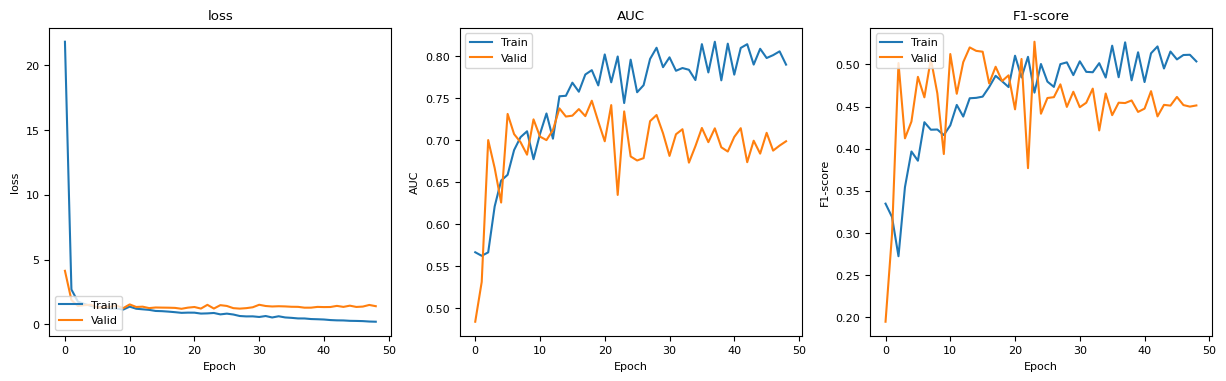

In [56]:
#@title 訓練曲線
plt.rcParams.update({'font.size': 8})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot training & validation accuracy values
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('loss')
ax1.set(ylabel='loss', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='lower left')

# Plot training & validation loss values
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('AUC')
ax2.set(ylabel='AUC', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation F1-score values
ax3.plot(history.history['f1'])
ax3.plot(history.history['val_f1'])
ax3.set_title('F1-score')
ax3.set(ylabel='F1-score', xlabel='Epoch')
ax3.legend(['Train', 'Valid'], loc='upper left')

plt.show()

In [57]:
# 儲存模型 save model
h5_file_path = model_dir + "/epoch_end.h5"
model.save(h5_file_path)

# 4 評估 Evaluation

In [58]:
# 讀取模型存檔
h5_file_path = model_dir + "/best_model.h5"
# h5_file_path = model_dir + "/epoch_end.h5"
model = load_model(h5_file_path, compile=False)

In [59]:
# 預測 驗證集 predict valid_set eagerly
y_true = []
y_pred = []
for x, y in valid_generator:
    y_true.append(y)
    pred = model(x, training=False).numpy()
    y_pred.append(pred)
    print(".", end="")
print("Done!")

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

..Done!
y_true shape: (76, 5)
y_pred shape: (76, 5)


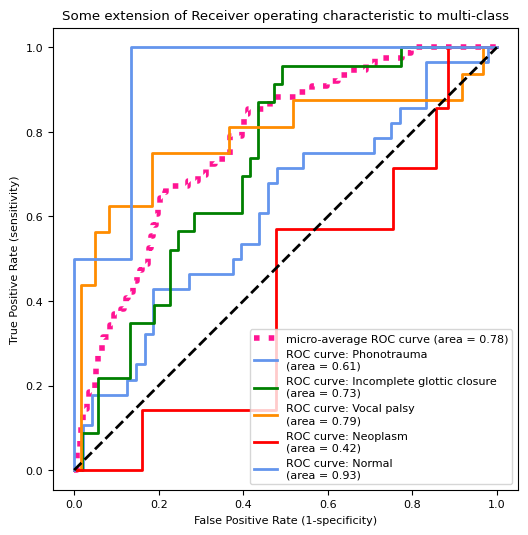

In [60]:
#@title 畫出 ROC曲線
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
micro_avg = True  #@param {type:"boolean"}
marco_avg = False  #@param {type:"boolean"}

# 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
lw = 2
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

if micro_avg == True:
    # 計算 微觀平均曲線
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

if marco_avg == True:
    # 計算 宏觀平均曲線
    # Compute macro-average ROC curve and ROC area
    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

#### 畫出所有 ROC 曲線 ####
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

if micro_avg == True:
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

if marco_avg == True:
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()

<Figure size 1400x600 with 0 Axes>

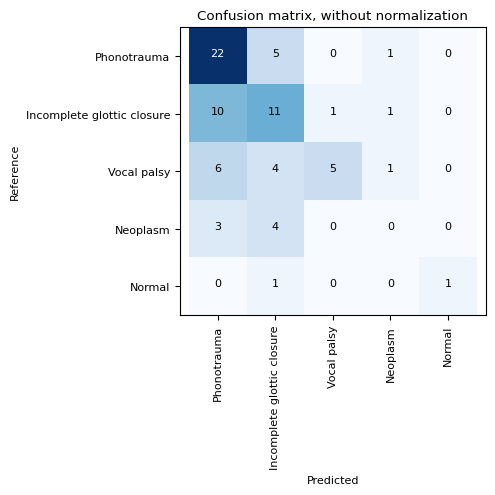

<Figure size 1400x600 with 0 Axes>

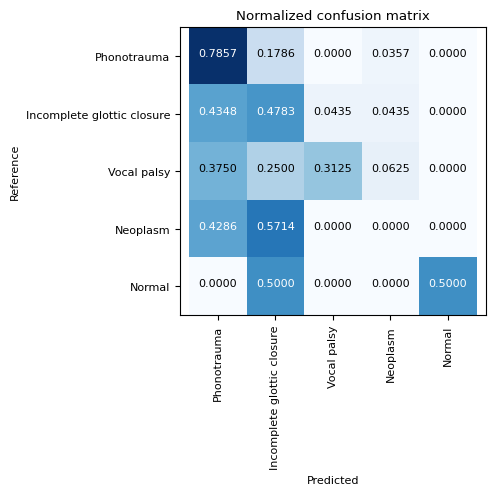

In [61]:
#@title 畫出 混淆矩陣 confusion matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 8})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Reference')
    ax.set_xlabel('Predicted')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))  #
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
# Plot normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [62]:
#@title 多分類報告 classification report
report = classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASSES, digits=4)
print(report)

                            precision    recall  f1-score   support

               Phonotrauma     0.5366    0.7857    0.6377        28
Incomplete glottic closure     0.4400    0.4783    0.4583        23
               Vocal palsy     0.8333    0.3125    0.4545        16
                  Neoplasm     0.0000    0.0000    0.0000         7
                    Normal     1.0000    0.5000    0.6667         2

                  accuracy                         0.5132        76
                 macro avg     0.5620    0.4153    0.4434        76
              weighted avg     0.5326    0.5132    0.4869        76



In [63]:
#@title UAR (Unweighted Average Recall)
uar = recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
print("Validation UAR (Unweighted Average Recall) :", uar)

Validation UAR (Unweighted Average Recall) : 0.41529503105590065


# 5 預測 Prediction
對測試資料作答 (public dataset / private dataset)

In [64]:
# 讀取資料表
df = pd.read_csv("/Users/zhongyongting/1112/ai_workshop/Data/Public dataset/test_datalist_public.csv")
#df = pd.read_csv("/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Private Testing Dataset/test_datalist_public+private.csv")
df = df.loc[df['Sex'] == 1]
df

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
1,1100j0u,1,50,0,0,0,0,0,0,0,...,1,2,2,0,1,0,0,0,0,30.0
2,0G00r5c,1,41,1,1,0,0,0,0,0,...,5,2,3,0,0,0,0,0,0,29.0
5,1302gp2,1,50,1,1,1,0,1,0,0,...,3,2,1,0,0,0,0,0,0,30.0
6,0T00ted,1,31,1,1,1,1,0,1,1,...,2,1,1,0,0,0,0,0,0,38.0
9,0W00632,1,60,0,0,0,1,1,0,0,...,3,1,3,0,1,0,0,0,0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,1300hnu,1,32,1,1,1,1,1,0,0,...,1,2,1,0,0,0,0,0,0,24.0
484,1301s8k,1,61,0,0,0,0,0,0,0,...,3,2,2,0,0,0,0,0,0,13.0
489,0H010k0,1,64,0,1,0,1,0,0,0,...,1,2,1,0,0,0,0,0,0,21.0
491,0T02iml,1,48,0,0,0,0,0,0,0,...,2,1,3,0,0,0,0,0,0,10.0


In [65]:
# 1.1 添加音檔路徑：檔案名稱為 {ID}.wav
test_voice_dir = "/Users/zhongyongting/1112/ai_workshop/Data/Public dataset/test_data_public"
# test_voice_dir = "/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Private Testing Dataset/test_data_public+private"
df['path'] = df['ID'].map(lambda x: f"{test_voice_dir}/{x}.wav")
df

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,path
1,1100j0u,1,50,0,0,0,0,0,0,0,...,2,2,0,1,0,0,0,0,30.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
2,0G00r5c,1,41,1,1,0,0,0,0,0,...,2,3,0,0,0,0,0,0,29.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
5,1302gp2,1,50,1,1,1,0,1,0,0,...,2,1,0,0,0,0,0,0,30.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
6,0T00ted,1,31,1,1,1,1,0,1,1,...,1,1,0,0,0,0,0,0,38.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
9,0W00632,1,60,0,0,0,1,1,0,0,...,1,3,0,1,0,0,0,0,20.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,1300hnu,1,32,1,1,1,1,1,0,0,...,2,1,0,0,0,0,0,0,24.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
484,1301s8k,1,61,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,13.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
489,0H010k0,1,64,0,1,0,1,0,0,0,...,2,1,0,0,0,0,0,0,21.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...
491,0T02iml,1,48,0,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,10.0,/Users/zhongyongting/1112/ai_workshop/Data/Pub...


In [68]:
# 讀取模型存檔
h5_file_path = "/Users/zhongyongting/1112/ai_workshop/model/CNN_Unisex_Sex1/best_model.h5"  # <-- 確認模型檔案存放的路徑
model = load_model(h5_file_path, compile=False)

In [71]:
# 取得預測結果
y_pred = model.predict(test_generator)
print("y_pred shape =", y_pred.shape)
y_pred

2023-05-17 17:14:02.247688: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: KeyError: 2
Traceback (most recent call last):

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 2263, in pandas._libs.hashtable.Int64HashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 2273, in pandas._libs.hashtable.Int64HashTable.get_item

KeyError: 2


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 266, 

UnknownError: Graph execution error:

KeyError: 2
Traceback (most recent call last):

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 2263, in pandas._libs.hashtable.Int64HashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 2273, in pandas._libs.hashtable.Int64HashTable.get_item

KeyError: 2


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/fv/8l150xdd1s9g5kp4hdz1c8c40000gn/T/__autograph_generated_file54gvlg0u.py", line 17, in py_preproc
    path = ag__.ld(df_trans).loc[ag__.ld(idx), 'path']
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexing.py", line 1066, in __getitem__
    return self.obj._get_value(*key, takeable=self._takeable)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/frame.py", line 3924, in _get_value
    row = self.index.get_loc(index)
          ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3804, in get_loc
    raise KeyError(key) from err

KeyError: 2


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_86688]

2023-05-17 17:14:02.321513: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: KeyError: 271
Traceback (most recent call last):

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 2263, in pandas._libs.hashtable.Int64HashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 2273, in pandas._libs.hashtable.Int64HashTable.get_item

KeyError: 271


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 2